# Unsupervised Learning 

As the name suggests unsupervised learning, contrary to supervised learning, can find patterns in *unlabelled* data. Again, here we try to cover some of the more commonly used unsupervised learning technqies:
- [Dimension Reduction](#dim_reduction)
- [Clustering](#clustering)
- [Anomaly Detection](#anomaly)

I'm including this again because I like it so much.
![sklearn classifier overview](http://scikit-learn.org/stable/_static/ml_map.png)

In [1]:
import numpy as np
import matplotlib
import seaborn as sns

from sklearn import datasets, model_selection

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [75]:
# This is just a handy plotting function for later
from matplotlib.colors import ListedColormap

def visualise_decision_surface(X, y, clf):

    Z = clf.fit_predict(X)
    
    plt.scatter(X[:, 0], X[:, 1], c=Z)
            
    plt.show()

## Dimension Reduction <a id='dim_reduction'></a>

One of the simplest unsupervised learning techniques to understand is that of dimension reduction. There are many different ways to reduce the dimensionality of your problem but the reasons for it are straight forward. As your feature vector grows in length it becomes more and more computationally expensive to process. By applying dimension reduction you may be able to obtain similar performance as that of the whole vector but with a fraction of the compute time and power.

Another benefit of dimension reduction is it's ability to reduce some noise. Sometimes your feature vector may contain some redundant features, or information that doesn't contribute very much to the problem you are trying to solve. By applying dimension reduction you may be able to smooth away some of the noise introduced by these redundant features. In this case applying dimension reduction may actually improve the perfomance of your algorithm.

Finally one of the simplest reasons you may need to use dimension reduction is for visualisation. When you start working with feature vectors that are longer than 3 dimensions you very quickly begin to lose any intuition. By reducing the number of dimensions of your dataset down to something that you can easily plot, you might be able to get a feel for how points are distributed in the higher dimensional space.

### Principle Component Analysis

Everyones favourite dimension reduction algorithm, Principle Component Analysis or PCA, is a dimension reduction technique that aims to preserve variance in the dataset. In general terms PCA essentially finds the eigen vectors that correspond to the $n$ largest eigen values of the dataset, as these "components" contribute most to the overall variance of the dataset, and projects the dataset into that eigen space.

More formally, you can extract the eigen vectors of you training set ${\bf X}$ using [Singular Value Decomposition](https://en.wikipedia.org/wiki/Singular-value_decomposition) (SVD). SVD will decompose a matrix into the dot product of three matrices ${\bf X} = {\bf U} \cdot \Sigma \cdot {\bf V}^T$, where the diagonal elements of $\Sigma$ can be used to obtain the eigenvalues and the columns of ${\bf V}^T$ are the eigenvectors of ${\bf X}$. You can now simply take the first $d$ columns of ${\bf V}^T$ as the components of your new eigen space and project you data set into that space. This can be done pretty simply using the dot product

$${\bf X}_{\textrm{d-proj}} = {\bf X}\cdot {\bf W}_d$$
where ${\bf W}_d$ is the matrix composed of the first $d$ columns of ${\bf V}^T$.

In [2]:
from sklearn.decomposition import PCA

NUMBER_OF_NUMBERS = 5

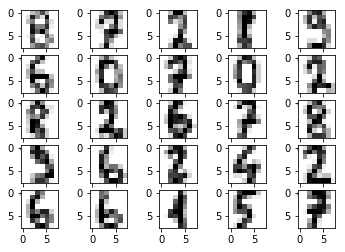

In [8]:
# Load the MNIST hand drawn digits dataset
# The sklearn version is reduced both in the number of instances
# and the resolution of the image.
mnist = datasets.load_digits()
X_mnist = mnist["data"]
y_mnist = mnist["target"]
number_of_instances = len(X_mnist)

# Plot a square array of sample digits for instpection
f, axarr = plt.subplots(NUMBER_OF_NUMBERS, NUMBER_OF_NUMBERS)
np.random.seed(12345) # Fix the seed so we can grab the same digits next
for i in range(NUMBER_OF_NUMBERS):
    for j in range(NUMBER_OF_NUMBERS):
        digit = X_mnist[np.random.randint(0, number_of_instances+1)].reshape((8,8))
        axarr[i, j].imshow(digit, cmap=matplotlib.cm.binary)

plt.show()

In [9]:
# Create PCA object with 9 components
# NOTE: the number of components here does not need to be a 
# perfect square as the resulting dimensions no longer
# directly correlate to pixel values
pca = PCA(n_components=9)
# Reduce the dimensionality of the MNIST digits
X_mnist_reduced = pca.fit_transform(X_mnist)
# Transform the digits back to there original resolution
# This process is lossy and should illustrate the loss of information
# in the images
X_mnist_recovered = pca.inverse_transform(X_mnist_reduced)

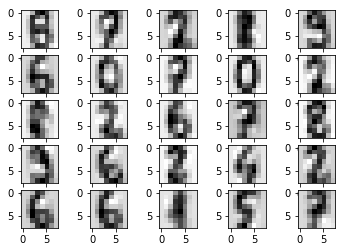

In [10]:
# Plot the reduced dimensionality digits to see the effect
f, axarr = plt.subplots(NUMBER_OF_NUMBERS, NUMBER_OF_NUMBERS)
np.random.seed(12345)
for i in range(NUMBER_OF_NUMBERS):
    for j in range(NUMBER_OF_NUMBERS):
        digit = X_mnist_recovered[np.random.randint(0, number_of_instances+1)].reshape((8,8))
        axarr[i, j].imshow(digit, cmap=matplotlib.cm.binary)

plt.show()

The first question that often gets asked by practitioners of PCA is how many components do I need? The easiest way to decide that is to [plot the cumulative sum of the variance ratio](http://jotterbach.github.io/2016/03/24/Principal_Component_Analysis/) as a function of $n$, the number of components. You will see that at some point you start to get diminishing returns for additional components.

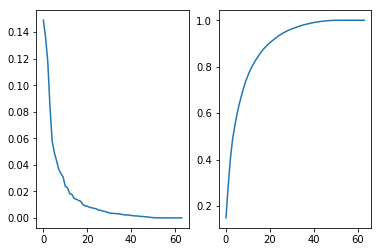

In [16]:
# Choose the largest number of components possible
# This will generate a cumulative sum for each number
# of components less than that chosen
pca = PCA(n_components=64)  # 64 is the max as that is the size of the input
pca.fit(X_mnist)
cumsum = np.cumsum(pca.explained_variance_ratio_)
    
f, (ax1, ax2) = plt.subplots(1,2)
ax1.plot(pca.explained_variance_ratio_)
ax2.plot(cumsum)
plt.show()

### Incremental Principle Component Analysis

Incremental Principle Component Analysis (IPCA) is a technique for processing the dataset in mini batches rather than all at once. This would be an example of an "online" learning approach compared to the "batch" learning approach we just saw above. Have a play around with the number of batches and see how that effects the final result. Hopefully you will find that the closer the number of batches is to one, the closer the online approach is to the batch approach. You will just need to make sure that, mini_batch_size > n_components.

In [19]:
from sklearn.decomposition import IncrementalPCA

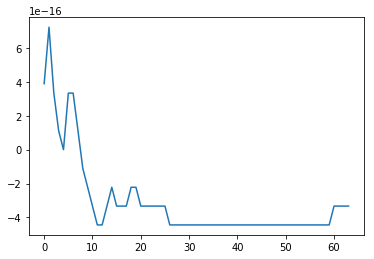

In [20]:
n_batches = 25
inc_pca = IncrementalPCA(n_components=64)
for X_batch in np.array_split(X_mnist, n_batches):
    inc_pca.partial_fit(X_batch)
    
inc_cumsum = np.cumsum(inc_pca.explained_variance_ratio_)
plt.plot(inc_cumsum-cumsum)
plt.show()

### Kernel Principle Component Analysis

Just like we saw in the SVM section of the supervised learning notebook, PCA can also have an embedded kernel. Here we have a look at three different kernel types for the swiss roll dataset. Can you see a difference between the projections? Is it obvious why these differences occur?

In [21]:
from sklearn.decomposition import KernelPCA

from mpl_toolkits.mplot3d.axes3d import Axes3D

In [22]:
X, y = datasets.make_swiss_roll(n_samples=10000, noise=0.25)

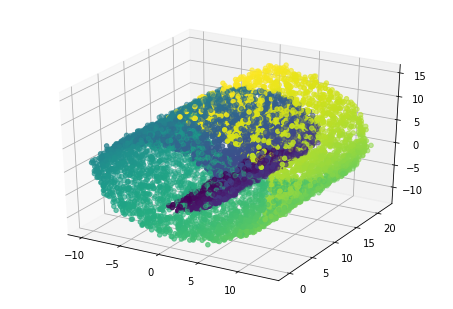

In [23]:
fig = plt.figure()
ax = Axes3D(fig) 
ax.scatter(X[:,0], X[:,1], X[:,2], c=y)
plt.show()

In [24]:
rbf_pca = KernelPCA(n_components=2, kernel="rbf", gamma=0.04)
X_reduced = rbf_pca.fit_transform(X)

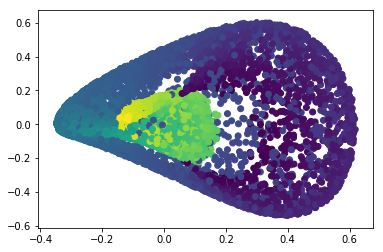

In [25]:
plt.scatter(X_reduced[:,0], X_reduced[:,1], c=y)
plt.show()

In [26]:
linear_pca = PCA(n_components=2)
X_reduced_linear = linear_pca.fit_transform(X)

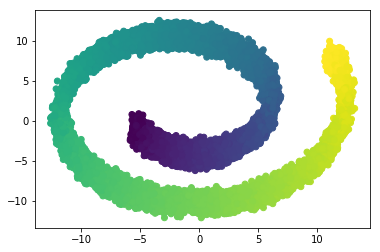

In [27]:
plt.scatter(X_reduced_linear[:,0], X_reduced_linear[:,1], c=y)
plt.show()

In [26]:
sigmoid_pca = KernelPCA(n_components=2, kernel="sigmoid", gamma=0.001)
X_reduced_sigmoid = sigmoid_pca.fit_transform(X)

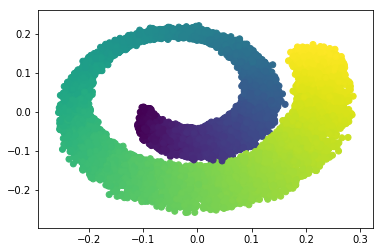

In [27]:
plt.scatter(X_reduced_sigmoid[:,0], X_reduced_sigmoid[:,1], c=y)
plt.show()

### Locally Linear Embedding 

A different approach to the of PCA, locally linear embedding, LLE, will preserve manifolds. It works by measuring how each instance linearly relates to its closest neighbours, and then looking for a lower dimensional representation which preserves this relationship. Explicitly, it tries to find the set of weights that minimise the distance between a point ${\bf x}^{(i)}$ and the linear combination of its neighbours $\sum_{j=1}^m w_{i,j}{\bf x}^{(j)}$

$$ \hat{\bf W} = \underset{{\bf W}}{\textrm{argmin}} \sum_{i=1}^m \left|\left| {\bf x}^{(i)} - \sum_{j=1}^m w_{i,j} {\bf x}^{(j)}\right|\right|^{2}$$

Then it tries to find a lower dimensional mapping such that the same distance is minimised in the new space

$$ \hat{\bf Z} = \underset{{\bf Z}}{\textrm{argmin}} \sum_{i=1}^m \left|\left| {\bf z}^{(i)} - \sum_{j=1}^m \hat{w}_{i,j} {\bf z}^{(j)}\right|\right|^{2}$$

In [28]:
from sklearn.manifold import LocallyLinearEmbedding

In [31]:
lle = LocallyLinearEmbedding(n_components=2, n_neighbors=50)
X_reduced_lle = lle.fit_transform(X)

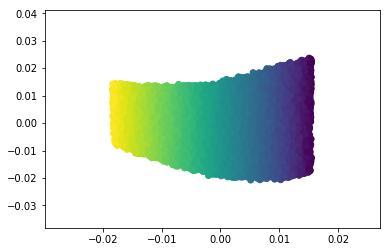

In [32]:
plt.scatter(X_reduced_lle[:,0], X_reduced_lle[:,1], c=y)
plt.show()

### t-Stochiastic Neighbour Embedding

Another manifold preserver it acts similarly to LLE however instead of finding the weights for the local combination it models the distribution of distances in the original and target spaces. It then tries to find the target space the minimises the [Kullback–Leibler divergence](https://en.wikipedia.org/wiki/Kullback–Leibler_divergence) of the two distributions.

The `scikit_learn` implementation of t-SNE can be a bit slow. Recently I have found a multicore implementation that is a bit faster and is just a quick to install. Check out [MulticoreTSNE](https://github.com/DmitryUlyanov/Multicore-TSNE)

In [33]:
from sklearn.manifold import TSNE
# from MulticoreTSNE import MulticoreTSNE as TSNE

In [35]:
tsne = TSNE()
# tsne = TSNE(n_jobs=4)
X_reduced_tsne = tsne.fit_transform(X)

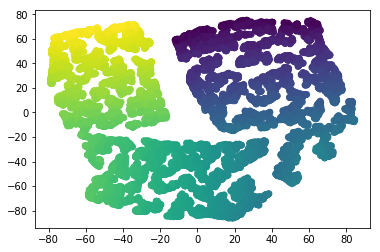

In [36]:
plt.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=y)
plt.show()

### UMAP

[Uniform Manifold Approximation and Projection](https://arxiv.org/abs/1802.03426) (UMAP) is a relatively new technique that is founded in a mathematically sound basis. It is usually faster than t-SNE and produces results where the Euclidean distance in the projected space can be interpreted as holding meaning. That is distances in the projected space represent those in the original space. The team have also developed a fast `scikit-learn`-esque [implementation for Python](https://github.com/lmcinnes/umap), that be installed with `conda` or `pip`.

In [38]:
from umap import UMAP

In [39]:
umap = UMAP()
X_reduced_umap = umap.fit_transform(X)

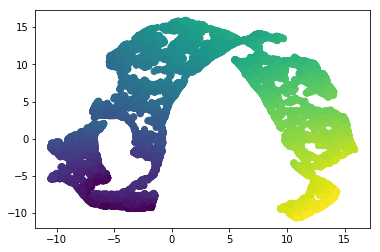

In [41]:
plt.scatter(X_reduced_umap[:,0], X_reduced_umap[:,1], c=y)
plt.show()

### Autoencoder 

An autoencoder is a type of artificial neural network (ANN) that can learn low dimensional representations of higher dimensional data. We will not cover ANNs in depth here as we will go over them in the deep learning session later. 

![Autoencoder image](https://www.jeremyjordan.me/content/images/2018/03/Screen-Shot-2018-03-07-at-8.24.37-AM.png)

Here we are using TensorFlow to build the neural network.

In [44]:
import tensorflow as tf
from tensorflow.contrib.layers import fully_connected

C:\Users\jam19e\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [45]:
n_inputs = 3 # 3D inputs
n_hidden = 2 # 2D codings
n_outputs = n_inputs

learning_rate = 0.01

X = tf.placeholder(tf.float32, shape=[None, n_inputs])
hidden = fully_connected(X, n_hidden, activation_fn=None)
outputs = fully_connected(hidden, n_outputs, activation_fn=None)

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))  # MSE

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(reconstruction_loss)

init = tf.global_variables_initializer()

In [46]:
X_autoencoder, y_autoencoder = datasets.make_s_curve(n_samples=1000, noise=0.01)

X_autoencoder_train, X_autoencoder_test, y_autoencoder_train, y_autoencoder_test = model_selection.train_test_split(X_autoencoder, y_autoencoder)

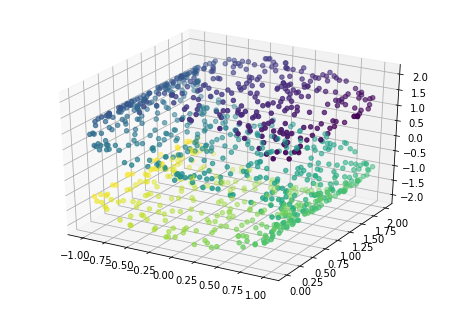

In [47]:
fig = plt.figure()
ax = Axes3D(fig) 
ax.scatter(X_autoencoder[:,0], X_autoencoder[:,1], X_autoencoder[:,2], c=y_autoencoder)
plt.show()

In [59]:
n_iterations = 1000
codings = hidden # The output of the hidden layer provides the codings

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        training_op.run(feed_dict={X: X_autoencoder_train})  # no labels (unsupervised)
    codings_val = codings.eval(feed_dict={X: X_autoencoder_test})

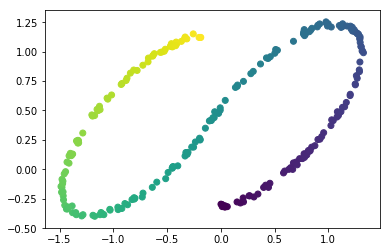

In [60]:
plt.scatter(codings_val[:, 0], codings_val[:, 1], c=y_autoencoder_test)
plt.show()

## Clustering 

Clustering seeks to find groups (or clusters) of similar data points in a given data set in an unsupervised way.

### k-Means Clustering 

k-means clustering will find $k$ of the most optimal centroids in your dataset. It does so by minimising the squared deviations of points in the same cluster. If our original dataset ${\bf X} = \{{\bf x}_1, {\bf x}_2, \dots, {\bf x}_m\}$ is cluster into $k$ sets ${\bf S} = \{{\bf x}_1, {\bf x}_2, \dots, {\bf x}_k\}$ then we are trying to find the $k$ sets such that

$${\bf S} = \underset{{\bf S}}{\textrm{argmin}}\sum_{i=1}^{k}\frac{1}{2|S_i|}\sum_{{\bf x}, {\bf y} \in {\bf S}_i} ||{\bf x} - {\bf y}||^2$$

![kmeans gif](https://media.giphy.com/media/12vVAGkaqHUqCQ/giphy.gif)

In [69]:
from sklearn.cluster import KMeans

In [86]:
# Create a dataset of four blobs or clusters
X_blobs, y_blobs = datasets.make_blobs(n_samples=1000, n_features=2, centers=5, cluster_std=0.5)

In [87]:
# Create kmeans cluster-er
kmeans_clstr = KMeans(n_clusters=4)
# And fit it to the dataset
kmeans_clstr.fit(X_blobs)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

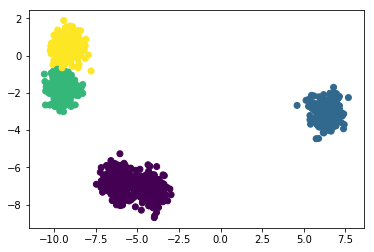

In [88]:
visualise_decision_surface(X_blobs, y_blobs, kmeans_clstr)

Well alright, that seemed to work pretty well. But I can imagine a scenario when it probably wouldn't work so well.

In [77]:
# Create two concentric circles representing different clusters
X_circles, y_circles = datasets.make_circles(n_samples=1500, factor=0.5, noise=0.05)

In [78]:
kmeans_clstr = KMeans(n_clusters=2)
kmeans_clstr.fit(X_circles)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

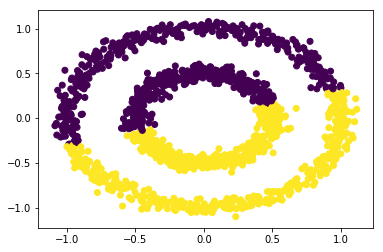

In [79]:
visualise_decision_surface(X_circles, y_circles, kmeans_clstr)

Hmmm, not so great this time. There are other clustering techniques that can do better. Have a look at spectral clustering

In [27]:
from sklearn.cluster import SpectralClustering

In [28]:
spectral_clstr = SpectralClustering(n_clusters=2,
                                    affinity="nearest_neighbors")
spectral_clstr.fit(X_circles)

/Users/miMacbookPro/anaconda/envs/introtoml/lib/python3.6/site-packages/sklearn/manifold/spectral_embedding_.py:234: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


SpectralClustering(affinity='nearest_neighbors', assign_labels='kmeans',
          coef0=1, degree=3, eigen_solver=None, eigen_tol=0.0, gamma=1.0,
          kernel_params=None, n_clusters=2, n_init=10, n_jobs=1,
          n_neighbors=10, random_state=None)

/Users/miMacbookPro/anaconda/envs/introtoml/lib/python3.6/site-packages/sklearn/manifold/spectral_embedding_.py:234: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


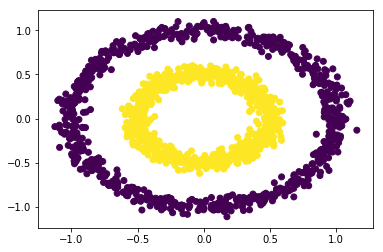

In [29]:
visualise_decision_surface(X_circles, y_circles, spectral_clstr)

Nice! Much better. Why not play around with some different [affinities](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.SpectralClustering.html#sklearn.cluster.SpectralClustering)?

## Anomaly Detection <a id='anomaly'></a>

Scikit-Learn has some great anomaly detectors built in as well. Check the [documentation](http://scikit-learn.org/stable/modules/outlier_detection.html) on the different methods available.

In [89]:
from sklearn import svm
from sklearn.preprocessing import LabelEncoder

In [91]:
# This dataset monitors network traffic
# We want to be able to identify traffic that is
# out of the ordinary.
# It is a little large so it might take a few minutes to 
# download
kddcup99 = datasets.fetch_kddcup99(subset="SA", percent10=True)

In [35]:
X_kddcup99 = kddcup99["data"][:10000,:]
y_kddcup99 = kddcup99["target"][:10000]

print(X_kddcup99.shape)
print(X_kddcup99[1])

labeler = LabelEncoder()
X_kddcup99[:,1] = labeler.fit_transform(X_kddcup99[:,1])
X_kddcup99[:,2] = labeler.fit_transform(X_kddcup99[:,2])
X_kddcup99[:,3] = labeler.fit_transform(X_kddcup99[:,3])

X_kddcup99_train, X_kddcup99_test, y_kddcup99_train, y_kddcup99_test = model_selection.train_test_split(X_kddcup99, y_kddcup99)

print(X_kddcup99[1])

(10000, 41)
[0 1 6 4 239 486 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 8 8 0.0 0.0 0.0 0.0 1.0
 0.0 0.0 19 19 1.0 0.0 0.05 0.0 0.0 0.0 0.0 0.0]
[0 1 6 4 239 486 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 8 8 0.0 0.0 0.0 0.0 1.0
 0.0 0.0 19 19 1.0 0.0 0.05 0.0 0.0 0.0 0.0 0.0]


In [33]:
clf = svm.OneClassSVM(nu=0.1, kernel="poly")
clf.fit(X_kddcup99_train)

OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma='auto', kernel='poly',
      max_iter=-1, nu=0.1, random_state=None, shrinking=True, tol=0.001,
      verbose=False)

In [34]:
predictions = clf.predict(X_kddcup99_test)
num_pred_outliers = len(predictions[predictions == 1.])
num_test_outliers = len(y_kddcup99_test[y_kddcup99_test != "normal"])
print(num_pred_outliers)
print(num_test_outliers)

2247
2500
